# This notebook describes the ongoing profast data analysis


In [37]:
from functools import reduce

import pandas as pd
import numpy as np
from tqdm import tqdm

from tasrif.data_readers.siha_dataset import \
    SihaSleepDataset, \
    SihaStepsIntradayDataset, \
    SihaCaloriesIntradayDataset, \
    SihaDistanceIntradayDataset, \
    SihaHeartRateIntradayDataset, \
    SihaVeryActiveMinutesDataset, \
    SihaLightlyActiveMinutesDataset, \
    SihaSedentaryMinutesDataset, \
    SihaModeratelyActiveMinutesDataset, \
    SihaTimeInHeartRateZonesDataset, \
    SihaStepsDataset, \
    SihaCaloriesDataset, \
    SihaDistanceDataset, \
    SihaCgmDataset, \
    SihaEmrDataset, \
    SihaSleepIntradayDataset

Change the path below to where the data actually is

In [10]:
datapath='../../data/profast2020/'

Below, we defined a set of helper functions for the analysis.
Some of them could be eventually integrated back to Tasrif

In [11]:
# Helper functions
def read_data(module, class_name_mapping):

    ds = module(folder=datapath)

    df_tmp = ds.processed_dataframe()
    df_tmp = df_tmp.reset_index()

    if "time" not in df_tmp:
        df_tmp = df_tmp.rename(columns={"dateTime": "time"})

    df_tmp = df_tmp.rename(columns={"value": class_name_mapping[module]})
    return df_tmp


def ramadan_flag(t, start_ramadan=pd.Timestamp(2020, 4, 23, 0, 0, 0),
                 end_ramadan=pd.Timestamp(2020, 5, 23, 23, 59, 59)):

    if (t >= start_ramadan) & (t <= end_ramadan):
        return 1
    elif t < start_ramadan:
        return 0
    else:
        return 2

def get_participant(df, pid):
    return df[df["patientID"] == pid]

def get_before_ramadan(df):
    return df[df["Ramadan"] == 0]

def get_ramadan(df):
    return df[df["Ramadan"] == 1]

def corr_per_day(df):
    return df.groupby(pd.Grouper(key='time',freq='D'))[["Calories", "mets", "Steps", "Distance", "CGM"]].corr()

def get_data_day(df, month, day, time_col="time"):
    return df[(df[time_col].dt.month == month) & (df[time_col].dt.day == day)]

def drop_days_below_min_steps(df, min_steps=1000, time_col="time", pid_col="patientID"):
    # Get number of steps in a day
    total_steps_day = df.groupby([pid_col, pd.Grouper(key=time_col,freq='D')])["Steps"].sum()

    # Find the <pids, days> to drop
    days_to_drop = total_steps_day[total_steps_day <= min_steps].index

    # Temporarily reindex dataframe with <pid, day>
    df_tmp = df.set_index([pid_col, df[time_col].dt.floor("D")])

    # Return only the <pids, days> that are not in the list to drop
    df_tmp = df_tmp.loc[~df_tmp.index.isin(days_to_drop)]

    # The first level of index (pid) needs to come back to the dataframe, but the second one (day) have to be dropped
    return df_tmp.reset_index(level=0).reset_index(drop=True)

def mean_per_day(df, metric, pid_col="patientID", time_col="time", remove_zero_steps=False):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0]
    else:
        df_tmp = df.copy()

    # Get average number of [steps, calories, ...] in a day
    mean_per_day = df_tmp.groupby([pid_col, pd.Grouper(key=time_col,freq='D')])[metric].mean()

    return mean_per_day


# First Goal: Combining intra day data

The cells below aim to combine the intra day FitBit and CGM data

In [12]:
class_name_mapping = {SihaCaloriesIntradayDataset: "Calories",
                      SihaStepsIntradayDataset: "Steps",
                      SihaDistanceIntradayDataset: "Distance",
                      SihaHeartRateIntradayDataset: "HeartRate",
                      SihaCgmDataset: "CGM"
}

# Read HR data:
df_intra = read_data(SihaHeartRateIntradayDataset, class_name_mapping)
# Resample to 15 min intervals
df_intra = df_intra.groupby("patientID")[["HeartRate", "time"]].resample(rule="15min",
                                                                         offset='00h00min',
                                                                         on="time").mean().reset_index()

for intraday_module in [SihaCaloriesIntradayDataset, SihaStepsIntradayDataset,
                         SihaDistanceIntradayDataset]:

    df_tmp = read_data(intraday_module, class_name_mapping)
    df_intra = pd.merge(df_intra, df_tmp, on=['patientID', 'time'], how='outer')

df_intra = df_intra.dropna()
df_intra.head(10)

patientID                time  HeartRate  level   mets   Calories  Steps  \
0         27 2020-02-16 10:45:00  79.733330    1.0  389.0  52.581131  348.0   
1         27 2020-02-16 11:00:00  80.199997    1.0  440.0  59.474800  412.0   
2         27 2020-02-16 11:15:00  78.000000    1.0  328.0  44.335758  179.0   
3         27 2020-02-16 11:30:00  74.599998    1.0  256.0  34.603519   67.0   
4         27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400  333.0   
5         27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151  312.0   
6         27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100    8.0   
7         27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238  529.0   
8         27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440  331.0   
9         27 2020-02-16 13:00:00  94.400002    1.0  417.0  56.365891  207.0   

   Distance  
0  0.167646  
1  0.198404  
2  0.086122  
3  0.032249  
4  0.160376  
5  0.150248  
6  0.003853  
7  0.254700  
8  0.159444  
9  0.099606

CGM data is sync'ed on a 15min interval round on the hour (i.e., HH:00, HH:15, HH:30, HH:45)

In [13]:
df_cgm = read_data(SihaCgmDataset, class_name_mapping)
df_cgm = df_cgm.groupby("patientID")[["CGM", "time"]].resample(rule="15min", offset='00h00min',
                                                               on="time").mean().reset_index()


In [14]:
df_intra = pd.merge(df_intra, df_cgm)

## Add Ramadan annotation

In [15]:
df_intra["Ramadan"] = df_intra["time"].apply(ramadan_flag)

# Quick and dirty data cleaning

In [16]:
print("Total number of epochs: %d" % df_intra.shape[0])
print("Total number of epochs without CGM: %d (%.2f%% of total)" % (df_intra["CGM"].isnull().sum(),
                                                                    100.*df_intra["CGM"].isnull().sum()/df_intra.shape[0]))

print("--- Removing invalid CGM epochs....")
df_intra = df_intra.dropna()
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

print("--- Removing days in which number of steps is smaller than 1000 (for the whole day)")
df_intra = drop_days_below_min_steps(df_intra)

print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

Total number of epochs: 93497
Total number of epochs without CGM: 40142 (42.93% of total)
--- Removing invalid CGM epochs....
	* Remaining number of epochs: 53355
--- Removing days in which number of steps is smaller than 1000 (for the whole day)
	* Remaining number of epochs: 48609


In [17]:
# Table: how many pre-ramadan, during ramadan, post-ramadan per user we have
data = []
for pid in df_intra["patientID"].unique():
    df_tmp = df_intra[df_intra["patientID"] == pid]
    tmp = {}
    tmp["pid"] = pid
    tmp["before"] = df_tmp[(df_tmp["Ramadan"] == 0)]["time"].dt.floor("d").unique().shape[0]
    tmp["during"] = df_tmp[(df_tmp["Ramadan"] == 1)]["time"].dt.floor("d").unique().shape[0]
    tmp["after"] = df_tmp[(df_tmp["Ramadan"] == 2)]["time"].dt.floor("d").unique().shape[0]
    tmp["total"] = tmp["before"] + tmp["during"] + tmp["after"]
    data.append(tmp)

data_availability = pd.DataFrame(data) # Check why total_2 is differnet from total_1

good_avail = data_availability[(data_availability["before"] >= 5) & (data_availability["during"] >= 5)]
good_avail.head(10)

pid  before  during  after  total
2    32      13       8      0     21
5    39       7      12      0     19
6    41      11      13      0     24
9    48      40      22      0     62
11   50      31      14      0     45
13   53       6      14      0     20
14   54      10      13      0     23
15   55      15      15      0     30
18   58      12      11      0     23
22   71      15      13      0     28

Keep only participants with good data avilability

In [18]:
print("Total number of epochs so far: %d" % df_intra.shape[0])
df_intra = df_intra[df_intra["patientID"].isin(good_avail["pid"].to_list())]
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])
print("\t* Remaining number of participants: %d" % df_intra["patientID"].unique().shape[0])

print("More than 5 days both before and during ramadan for %d participants." % (good_avail.shape[0]))
print("Ids: %s" % good_avail["pid"].to_list())


Total number of epochs so far: 48609
	* Remaining number of epochs: 37023
	* Remaining number of participants: 14
More than 5 days both before and during ramadan for 14 participants.
Ids: [32, 39, 41, 48, 50, 53, 54, 55, 58, 71, 75, 79, 81, 85]


# Simple matplotlib/pandas viz sucks

<AxesSubplot:xlabel='time'>

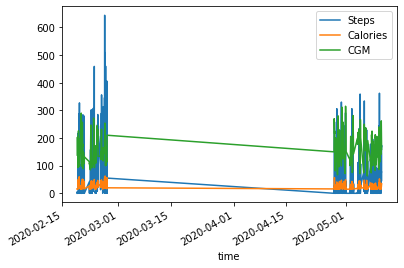

In [19]:
d = get_participant(df_intra, 39)
d.plot(x="time", y=["Steps", "Calories", "CGM"])

In [20]:
df_before_ramadan = corr_per_day(get_before_ramadan(d))
df_ramadan = corr_per_day(get_ramadan(d))

# ...But dataprep does a decent job

Below we created two separated reports, one for data before ramadan and another for data during ramadan to inspect for any clear differences, but I could not find anyone.


In [21]:
from dataprep.eda import create_report

  0%|          | 0/1167 [00:00<?, ?it/s]

DataPrep Report
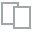
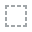
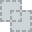
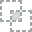
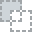
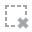
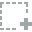
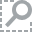
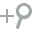
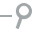
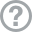
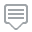
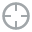
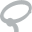
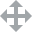
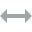
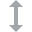
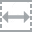
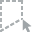
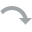
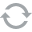
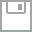
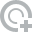
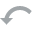
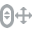
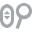
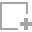
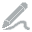
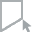
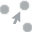
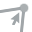
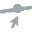

In [22]:
df_ramadan = get_before_ramadan(df_intra).reset_index(drop=True)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)


  0%|          | 0/1167 [00:00<?, ?it/s]

DataPrep Report
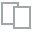
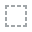
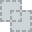
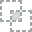
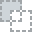
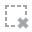
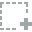
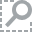
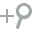
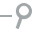
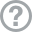
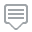
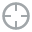
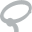
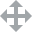
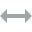
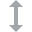
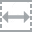
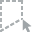
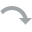
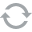
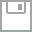
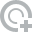
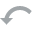
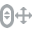
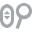
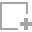
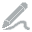
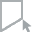
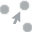
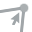
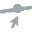

In [23]:
df_ramadan = get_ramadan(df_intra).reset_index(drop=True)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

# Correlations at user level.

The goal here is to combine data at user level and try to find useful correlations: e.g., participants taking drug X have a high correlation between number of steps and cgm values.

### Load EMR data and pivot it

In [25]:
df_emr = read_data(SihaEmrDataset, {SihaEmrDataset: "value"})
df_emr = df_emr.pivot(index="patientID", columns="variable", values="value")
df_emr["BMI"] = df_emr["BMI"].astype(np.float)

df_emr.head()

variable    BMI Cholesterol Creatinine Diabetes Duration  \
patientID                                                  
27         28.9         5.1         79                 6   
30         37.8         6.4         65                10   
31         26.0         3.2         81                17   
32         33.0         NaN        NaN                11   
34         28.7           3         96                 2   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable  Diastolic Blood Pressure  HDL HbA1c  LDL Systolic Blood Pressure  \
patientID                                                                    
27                              75    1   8.1  3.1                     121   
30                              86  1.1   7.8  4.5                     135   
31                              96  0.9   9.6  1.5                     134   
32                              77  NaN   7.8  NaN                     142   
34                              78  0.8    10  1.5                     146   

variable  Triglyceride  
patientID               
27                   2  
30                 1.7  
31                 1.6  
32                 NaN  
34                 1.5

In [26]:
# Tried to normalize the drug names
drugs = set([])
for tmp in df_emr["Diabetes Medication"]:
    for d in tmp.replace("+", ", ").split(","):
        if d.strip():
            # This should get rid of the dosage (Glargine 300 or Glargine 100 -> Glargine)
            d = d.split()[0].strip()
            drugs.add(d)


print("%d different drugs: %s" % (len(drugs), drugs))

for d in drugs:
    df_emr[d] = df_emr["Diabetes Medication"].apply(lambda x: d in x)

df_emr.head()

14 different drugs: {'Vildagliptin', 'Liraglutide', 'Glargine', 'Aspart', 'Glimepride', 'Degludec', 'Dapagliflozin', 'Dulaglutide', 'Metformin', 'Glicalzide', 'Sitagliptin', 'Pioglitazone', 'Exenatide', 'Empagliflozin'}


variable    BMI Cholesterol Creatinine Diabetes Duration  \
patientID                                                  
27         28.9         5.1         79                 6   
30         37.8         6.4         65                10   
31         26.0         3.2         81                17   
32         33.0         NaN        NaN                11   
34         28.7           3         96                 2   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable  Diastolic Blood Pressure  HDL HbA1c  LDL Systolic Blood Pressure  \
patientID                                                                    
27                              75    1   8.1  3.1                     121   
30                              86  1.1   7.8  4.5                     135   
31                              96  0.9   9.6  1.5                     134   
32                              77  NaN   7.8  NaN                     142   
34                              78  0.8    10  1.5                     146   

variable   ... Glimepride  Degludec  Dapagliflozin  Dulaglutide  Metformin  \
patientID  ...                                                               
27         ...      False     False          False        False      False   
30         ...      False     False           True        False       True   
31         ...      False     False          False        False       True   
32         ...      False     False           True        False       True   
34         ...      False     False          False        False      False   

variable   Glicalzide  Sitagliptin  Pioglitazone  Exenatide  Empagliflozin  
patientID                                                                   
27               True         True         False      False           True  
30              False         True          True      False          False  
31              False         True          True      False          False  
32              False         True         False      False          False  
34              False         True         False      False           True  

[5 rows x 25 columns]

In [27]:
df_means = pd.concat([mean_per_day(df_intra, "Steps", remove_zero_steps=True),
                      mean_per_day(df_intra, "Calories", remove_zero_steps=True),
                      mean_per_day(df_intra, "Distance", remove_zero_steps=True),
                      mean_per_day(df_intra, "mets", remove_zero_steps=True),
                      mean_per_day(df_intra, "HeartRate", remove_zero_steps=True),
                      mean_per_day(df_intra, "CGM", remove_zero_steps=True)
                      ], axis=1).reset_index()
df_means = df_means.groupby("patientID").mean()
df_means.head()

Steps   Calories  Distance        mets  HeartRate         CGM
patientID                                                                    
32         121.105591  50.556847  0.059519  340.060849  84.007599  125.269157
39          97.832428  28.477617  0.041499  287.885337  98.240784  176.231445
41         122.701607  53.818687  0.058185  381.774038  87.760277  113.726624
48         100.830505  27.874519  0.032886  283.883487  86.630280  135.871185
50         132.719299  45.185219  0.061840  326.035208  78.442734  104.788094

In [28]:
df_merged = pd.merge(df_means, df_emr, left_index=True, right_index=True)
df_merged.head()

Steps   Calories  Distance        mets  HeartRate         CGM  \
patientID                                                                       
32         121.105591  50.556847  0.059519  340.060849  84.007599  125.269157   
39          97.832428  28.477617  0.041499  287.885337  98.240784  176.231445   
48         100.830505  27.874519  0.032886  283.883487  86.630280  135.871185   
50         132.719299  45.185219  0.061840  326.035208  78.442734  104.788094   
53         159.439255  35.390106  0.069389  309.895863  86.437775  108.562859   

            BMI Cholesterol Creatinine Diabetes Duration  ... Glimepride  \
patientID                                                 ...              
32         33.0         NaN        NaN                11  ...      False   
39         22.0         2.5         84                12  ...      False   
48         30.3         NaN        NaN                11  ...      False   
50         33.8         5.5         91                23  ...       True   
53         29.0         3.2         69                12  ...      False   

          Degludec Dapagliflozin Dulaglutide Metformin Glicalzide Sitagliptin  \
patientID                                                                       
32           False          True       False      True      False        True   
39           False         False       False      True      False        True   
48           False         False       False      True      False        True   
50           False         False       False      True      False        True   
53           False          True       False      True      False        True   

           Pioglitazone  Exenatide  Empagliflozin  
patientID                                          
32                False      False          False  
39                 True      False          False  
48                False      False           True  
50                False      False          False  
53                 True      False          False  

[5 rows x 31 columns]

In [29]:
for d in drugs:
    df_drug = df_merged[df_merged[d] == True]
    print("People in the final dataset that took drug %s: %d" % (d, df_drug.shape[0]))

People in the final dataset that took drug Vildagliptin: 3
People in the final dataset that took drug Liraglutide: 2
People in the final dataset that took drug Glargine: 4
People in the final dataset that took drug Aspart: 1
People in the final dataset that took drug Glimepride: 1
People in the final dataset that took drug Degludec: 2
People in the final dataset that took drug Dapagliflozin: 5
People in the final dataset that took drug Dulaglutide: 1
People in the final dataset that took drug Metformin: 12
People in the final dataset that took drug Glicalzide: 1
People in the final dataset that took drug Sitagliptin: 8
People in the final dataset that took drug Pioglitazone: 4
People in the final dataset that took drug Exenatide: 0
People in the final dataset that took drug Empagliflozin: 2


In [30]:
# Compared the data for the 8 people with combo ["Metformin", "Sitagliptin"] against without (4)
df_grp1 = df_merged[((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]
df_grp2 = df_merged[~((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]

print("Corr CGM-HeartRate Grp1: %.3f, Grp2: %.3f" % (df_grp1.corr()["CGM"]["HeartRate"],
                                                     df_grp2.corr()["CGM"]["HeartRate"]))

Corr CGM-HeartRate Grp1: 0.881, Grp2: -0.287


# Basic Classification Models with the data above


In [32]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from pycaret.regression import *

In [34]:
def generate_slide_wins(df, start_seq=0, winsize="1h15t", time_col="time", label_col="CGM"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []

    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop
    df.reset_index().rolling(winsize, on=time_col, center=False)["index"].apply((lambda x: list_of_indices.append(x.tolist()) or 0))

    # Time-based win might be smaller than the expected size. We fix it by comparing the size of each
    # value in the list_of_indices with the size of the last element
    max_size = len(list_of_indices[-1])

    for idx in list_of_indices:
        if len(idx) != max_size:
            continue

        labels.append(df.loc[idx].iloc[-1][label_col])
        tmp_df = df.loc[idx[0:-1]].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        transformed_df.append(tmp_df)

    labels = pd.Series(labels)
    labels.name = "ground_truth"
    return seq_id + 1, pd.concat(transformed_df), labels

In [61]:
generate_slide_wins(df_intra.head(7), start_seq=0, winsize="1h15t")[2].shape

(3,)

In [62]:
signals = ["time", "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM"]

df_labels = []
df_timeseries = []
last_seq_id = 0

for pid in tqdm(df_intra["patientID"].unique()[:5]):

    print("PID:", pid)
    df_tmp = df_intra[df_intra["patientID"] == pid]

    last_seq_id, df_ts_tmp, df_label_tmp = generate_slide_wins(df_tmp[signals],
                                                               start_seq=last_seq_id,
                                                               winsize="1h")
    df_timeseries.append(df_ts_tmp)
    df_labels.append(df_label_tmp)


df_labels = pd.concat(df_labels)
df_timeseries = pd.concat(df_timeseries)

100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


PID: 32
PID: 39
PID: 41
PID: 48
PID: 50


In [63]:
extracted_features = extract_features(df_timeseries, column_id="seq_id", column_sort="time")

Feature Extraction: 100%|██████████| 30/30 [08:42<00:00, 17.41s/it]


In [65]:
impute(extracted_features)

HeartRate__variance_larger_than_standard_deviation  \
0                                                    1.0    
1                                                    0.0    
2                                                    1.0    
3                                                    1.0    
4                                                    1.0    
...                                                  ...    
12323                                                1.0    
12324                                                1.0    
12325                                                1.0    
12326                                                1.0    
12327                                                1.0    

       HeartRate__has_duplicate_max  HeartRate__has_duplicate_min  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
12323                           0.0                           0.0   
12324                           0.0                           0.0   
12325                           0.0                           0.0   
12326                           0.0                           0.0   
12327                           0.0                           0.0   

       HeartRate__has_duplicate  HeartRate__sum_values  HeartRate__abs_energy  \
0                           0.0             239.266678           19191.880859   
1                           0.0             227.600006           17268.435547   
2                           0.0             235.133331           18469.248047   
3                           0.0             244.799988           20013.980469   
4                           0.0             259.666656           22512.574219   
...                         ...                    ...                    ...   
12323                       0.0             226.466675           17416.439453   
12324                       0.0             207.733337           14667.635742   
12325                       0.0             189.666672           11999.791016   
12326                       0.0             196.666672           12900.925781   
12327                       0.0             190.800003           12184.410156   

       HeartRate__mean_abs_change  HeartRate__mean_change  \
0                        6.600002               -6.600002   
1                        1.200001                0.333332   
2                        4.200001                4.200001   
3                        4.066666                4.066666   
4                        4.000000                4.000000   
...                           ...                     ...   
12323                   11.066671              -10.933332   
12324                   12.566669               -9.433334   
12325                    1.966669                1.966669   
12326                    1.933334                1.933334   
12327                    6.400000               -3.333334   

       HeartRate__mean_second_derivative_central  HeartRate__median  \
0                                       5.733334          75.933334   
1                                       1.200001          75.933334   
2                                       2.666668          76.599998   
3                                      -2.800003          83.466667   
4                                       2.733337          84.733330   
...                                          ...                ...   
12323                                 -11.066669          82.733330   
12324                                  12.566669          64.000000   
12325                                  -1.166666          64.000000   
12326                        

In [66]:
features_filtered_direct = extract_relevant_features(df_timeseries, df_labels, column_id='seq_id', column_sort='time')
features_filtered_direct.head()


ValueError: The following ids are in the time series container but are missing in y: {4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6411, 6412, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159, 8160, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9356, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9647, 9648, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421, 10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509, 10510, 10511, 10512, 10513, 10514, 10515, 10516, 10517, 10518, 10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527, 10528, 10529, 10530, 10531, 10532, 10533, 10534, 10535, 10536, 10537, 10538, 10539, 10540, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10556, 10557, 10558, 10559, 10560, 10561, 10562, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10576, 10577, 10578, 10579, 10580, 10581, 10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590, 10591, 10592, 10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603, 10604, 10605, 10606, 10607, 10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642, 10643, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10664, 10665, 10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675, 10676, 10677, 10678, 10679, 10680, 10681, 10682, 10683, 10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693, 10694, 10695, 10696, 10697, 10698, 10699, 10700, 10701, 10702, 10703, 10704, 10705, 10706, 10707, 10708, 10709, 10710, 10711, 10712, 10713, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 10728, 10729, 10730, 10731, 10732, 10733, 10734, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10752, 10753, 10754, 10755, 10756, 10757, 10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10782, 10783, 10784, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10810, 10811, 10812, 10813, 10814, 10815, 10816, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825, 10826, 10827, 10828, 10829, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10845, 10846, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10860, 10861, 10862, 10863, 10864, 10865, 10866, 10867, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887, 10888, 10889, 10890, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905, 10906, 10907, 10908, 10909, 10910, 10911, 10912, 10913, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10927, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935, 10936, 10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945, 10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247, 11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11279, 11280, 11281, 11282, 11283, 11284, 11285, 11286, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 11403, 11404, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455, 11456, 11457, 11458, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623, 11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11638, 11639, 11640, 11641, 11642, 11643, 11644, 11645, 11646, 11647, 11648, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678, 11679, 11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11814, 11815, 11816, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843, 11844, 11845, 11846, 11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11859, 11860, 11861, 11862, 11863, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11873, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11921, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937, 11938, 11939, 11940, 11941, 11942, 11943, 11944, 11945, 11946, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267, 12268, 12269, 12270, 12271, 12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280, 12281, 12282, 12283, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327}

In [ ]:
assert features_filtered_direct.shape[0] == df_labels.shape[0]

In [ ]:
data = pd.concat([features_filtered_direct, df_labels], axis=1)
experiment = setup(data, target = 'ground_truth', session_id=42)
best_model = compare_models()


